## Import dependancies


In [1]:
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import data.make_dataset as make_dataset
import visualization.visualize as visualize
import features.build_features as build_features

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

DRAW_PLOTS = False

## Prepare data loading : set correct variable types


In [2]:
# Read column names
column_names = pd.read_csv(
    "../data/processed/application_train.csv", nrows=0
).columns.values

# Set column types according to fields description (https://static.openfoodfacts.org/data/data-fields.txt)
column_types = {
    col: "category"
    for col in column_names
    if col.startswith(("NAME_",))
    or col.endswith(("_TYPE"))
    or col
    in [
        "CODE_GENDER",
        "WEEKDAY_APPR_PROCESS_START",
        "FONDKAPREMONT_MODE",
        "HOUSETYPE_MODE",
        "WALLSMATERIAL_MODE",
        "EMERGENCYSTATE_MODE",
    ]
}
column_types |= {
    col: bool
    for col in column_names
    if col.startswith(("FLAG_", "REG_", "LIVE_"))
}


## Application and Test data loading and first observations


### Application training data


In [3]:
# Load application data
app_train_df = pd.read_csv(
    "../data/processed/application_train.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"],
)

# Application data features
app_train_df.head()


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1         Cash loans           M         False   
1      100003       0         Cash loans           F         False   
2      100004       0    Revolving loans           M          True   
3      100006       0         Cash loans           F         False   
4      100007       0         Cash loans           M         False   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0             True             0          202500.0    406597.5      24700.5   
1            False             0          270000.0   1293502.5      35698.5   
2             True             0           67500.0    135000.0       6750.0   
3             True             0          135000.0    312682.5      29686.5   
4             True             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...             False            False            False            False   
1  ...             False            False            False            False   
2  ...             False            False            False            False   
3  ...             False            False            False            False   
4  ...             False            False            False            False   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [4]:
# Application data columns info
app_train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(9)
memory usage: 187.7 MB


In [5]:
# Application data variables description
app_train_df.describe(include="all")


SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER  \
count   307511.000000  307511.000000             307511      307507   
unique            NaN            NaN                  2           2   
top               NaN            NaN         Cash loans           F   
freq              NaN            NaN             278232      202448   
mean    278180.518577       0.080729                NaN         NaN   
std     102790.175348       0.272419                NaN         NaN   
min     100002.000000       0.000000                NaN         NaN   
25%     189145.500000       0.000000                NaN         NaN   
50%     278202.000000       0.000000                NaN         NaN   
75%     367142.500000       0.000000                NaN         NaN   
max     456255.000000       1.000000                NaN         NaN   

       FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count        307511          307511  307511.000000      3.075110e+05   
unique            2               2            NaN               NaN   
top           False            True            NaN               NaN   
freq         202924          213312            NaN               NaN   
mean            NaN             NaN       0.417052      1.687979e+05   
std             NaN             NaN       0.722121      2.371231e+05   
min             NaN             NaN       0.000000      2.565000e+04   
25%             NaN             NaN       0.000000      1.125000e+05   
50%             NaN             NaN       0.000000      1.471500e+05   
75%             NaN             NaN       1.000000      2.025000e+05   
max             NaN             NaN      19.000000      1.170000e+08   

          AMT_CREDIT    AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
count   3.075110e+05  307499.000000  ...            307511           307511   
unique           NaN            NaN  ...                 2                2   
top              NaN            NaN  ...             False            False   
freq             NaN            NaN  ...            305011           307328   
mean    5.990260e+05   27108.573909  ...               NaN              NaN   
std     4.024908e+05   14493.737315  ...               NaN              NaN   
min     4.500000e+04    1615.500000  ...               NaN              NaN   
25%     2.700000e+05   16524.000000  ...               NaN              NaN   
50%     5.135310e+05   24903.000000  ...               NaN              NaN   
75%     8.086500e+05   34596.000000  ...               NaN              NaN   
max     4.050000e+06  258025.500000  ...               NaN              NaN   

       FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
count            307511           307511              265992.000000   
unique                2                2                        NaN   
top               False            False                        NaN   
freq             307355           307408                        NaN   
mean                NaN              NaN                   0.006402   
std                 NaN              NaN                   0.083849   
min                 NaN              NaN                   0.000000   
25%                 NaN              NaN                   0.000000   
50%                 NaN              NaN                   0.000000   
75%                 NaN              NaN                   0.000000   
max                 NaN              NaN                   4.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count              265992.000000               265992.000000   
unique                       NaN                         NaN   
top                          NaN                         NaN   
freq                         NaN                         NaN   
mean                    0.007000                    0.034362   
std                     0.110757                    0.204685   
min                     0.000000           

### Application testing data


In [6]:
# Load test data
app_test_df = pd.read_csv(
    "../data/processed/application_test.csv",
    dtype=column_types,
    true_values=["Y", "Yes", "1"],
    false_values=["N", "No", "0"],
    na_values=["XNA"],
)

# Test data features
app_test_df.head()


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001         Cash loans           F         False             True   
1      100005         Cash loans           M         False             True   
2      100013         Cash loans           M          True             True   
3      100028         Cash loans           F         False             True   
4      100038         Cash loans           M          True            False   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...            False            False            False            False   
1  ...            False            False            False            False   
2  ...            False            False            False            False   
3  ...            False            False            False            False   
4  ...            False            False            False            False   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [7]:
# Test data columns info
app_test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(8)
memory usage: 29.4 MB


In [8]:
# Test data variables description
app_test_df.describe(include="all")


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
count    48744.000000              48744       48744        48744   
unique            NaN                  2           2            2   
top               NaN         Cash loans           F        False   
freq              NaN              48305       32678        32311   
mean    277796.676350                NaN         NaN          NaN   
std     103169.547296                NaN         NaN          NaN   
min     100001.000000                NaN         NaN          NaN   
25%     188557.750000                NaN         NaN          NaN   
50%     277549.000000                NaN         NaN          NaN   
75%     367555.500000                NaN         NaN          NaN   
max     456250.000000                NaN         NaN          NaN   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count            48744  48744.000000      4.874400e+04  4.874400e+04   
unique               2           NaN               NaN           NaN   
top               True           NaN               NaN           NaN   
freq             33658           NaN               NaN           NaN   
mean               NaN      0.397054      1.784318e+05  5.167404e+05   
std                NaN      0.709047      1.015226e+05  3.653970e+05   
min                NaN      0.000000      2.694150e+04  4.500000e+04   
25%                NaN      0.000000      1.125000e+05  2.606400e+05   
50%                NaN      0.000000      1.575000e+05  4.500000e+05   
75%                NaN      1.000000      2.250000e+05  6.750000e+05   
max                NaN     20.000000      4.410000e+06  2.245500e+06   

          AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
count    48720.000000     4.874400e+04  ...            48744            48744   
unique            NaN              NaN  ...                2                1   
top               NaN              NaN  ...            False            False   
freq              NaN              NaN  ...            48668            48744   
mean     29426.240209     4.626188e+05  ...              NaN              NaN   
std      16016.368315     3.367102e+05  ...              NaN              NaN   
min       2295.000000     4.500000e+04  ...              NaN              NaN   
25%      17973.000000     2.250000e+05  ...              NaN              NaN   
50%      26199.000000     3.960000e+05  ...              NaN              NaN   
75%      37390.500000     6.300000e+05  ...              NaN              NaN   
max     180576.000000     2.245500e+06  ...              NaN              NaN   

       FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
count             48744            48744               42695.000000   
unique                1                1                        NaN   
top               False            False                        NaN   
freq              48744            48744                        NaN   
mean                NaN              NaN                   0.002108   
std                 NaN              NaN                   0.046373   
min                 NaN              NaN                   0.000000   
25%                 NaN              NaN                   0.000000   
50%                 NaN              NaN                   0.000000   
75%                 NaN              NaN                   0.000000   
max                 NaN              NaN                   2.000000   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count                42695.000000                42695.000000   
unique                        NaN                         NaN   
top                           NaN                         NaN   
freq                          NaN                         NaN   
mean                     0.001803                    0.002787   
std                      0.046132                    0.054037   
min                      0.000000   

## Exploratory Data Analysis (EDA)


### Look for empty columns

In [9]:
# Plot application columns emptiness ratio
if DRAW_PLOTS:
    visualize.plot_empty_values(app_train_df)


In [10]:
# Plot test columns emptiness ratio
if DRAW_PLOTS:
    visualize.plot_empty_values(app_test_df)


### Look at numerical variables


In [11]:
clean_app_train_df = build_features.drop_impossible_values(
    app_train_df,
    constraints={
        "AMT_INCOME_TOTAL": {"min": 0, "max": 20 * 1000 * 1000,},
        "DAYS_EMPLOYED": {"min": -100 * 365, "max": 0,},
        "AMT_REQ_CREDIT_BUREAU_QRT": {"min": 0, "max": 20,},
        "OBS_30_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 200,},
        "DEF_30_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 20,},
        "OBS_60_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 200,},
        "DEF_60_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 20,},
    },
)
clean_app_train_df = build_features.drop_outliers(
    clean_app_train_df, columns=["REGION_POPULATION_RELATIVE"],
)

# Draw the BoxPlots of each numeric column, split per Nutrition Grade
if DRAW_PLOTS:
    visualize.plot_boxes(
        dataframe=clean_app_train_df,
        plot_columns=[
            "AMT_INCOME_TOTAL",
            "AMT_CREDIT",
            "AMT_ANNUITY",
            "AMT_GOODS_PRICE",
            "DAYS_BIRTH",
            "DAYS_EMPLOYED",
            "OWN_CAR_AGE",
            "REGION_RATING_CLIENT",
            "REGION_RATING_CLIENT_W_CITY",
            "EXT_SOURCE_1",
            "EXT_SOURCE_2",
            "EXT_SOURCE_3",
            "DAYS_LAST_PHONE_CHANGE",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
        ],
        categorical_column="TARGET",
    )


In [12]:
clean_app_test_df = build_features.drop_impossible_values(
    app_test_df,
    constraints={
        "DAYS_EMPLOYED": {"min": -100 * 365, "max": 0,},
        "AMT_REQ_CREDIT_BUREAU_QRT": {"min": 0, "max": 20,},
        "OBS_30_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 200,},
        "DEF_30_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 20,},
        "OBS_60_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 200,},
        "DEF_60_CNT_SOCIAL_CIRCLE": {"min": 0, "max": 20,},
    },
)
clean_app_test_df = build_features.drop_outliers(
    clean_app_test_df, columns=["REGION_POPULATION_RELATIVE"],
)


### Look at categorical variables


In [13]:
if DRAW_PLOTS:
    visualize.plot_categories_bars(
        clean_app_train_df,
        plot_columns=[
            "NAME_CONTRACT_TYPE",
            "CODE_GENDER",
            "FLAG_OWN_CAR",
            "FLAG_OWN_REALTY",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "FLAG_MOBIL",
        ],
        categorical_column="TARGET",
    )


#### One Hot Encoding

No ordinal data => One Hot Encoding is better than Label Encoding


In [14]:
# one-hot encoding of categorical variables
encoded_app_train_df = pd.get_dummies(clean_app_train_df, dtype=bool)
encoded_app_test_df = pd.get_dummies(clean_app_test_df, dtype=bool)

train_labels = encoded_app_train_df["TARGET"]

# Align the training and testing data, keep only columns present in both dataframes
encoded_app_train_df, encoded_app_test_df = encoded_app_train_df.align(
    encoded_app_test_df, join="inner", axis=1
)

# Add the target back in
encoded_app_train_df["TARGET"] = train_labels

print("Training Features shape: ", encoded_app_train_df.shape)
print("Testing Features shape: ", encoded_app_test_df.shape)


Training Features shape:  (217560, 240)
Testing Features shape:  (34522, 239)


### Missing values imputation


In [15]:
if os.path.exists("../data/processed/imputed_application_train.csv"):
    imputed_app_train_df = pd.read_csv(
        "../data/processed/imputed_application_train.csv", index_col=0
    )
else:
    imputed_app_train_df = build_features.impute_missing_values(
        encoded_app_train_df
    )
    imputed_app_train_df.to_csv("../data/processed/imputed_application_train.csv")


if os.path.exists("../data/processed/imputed_application_test.csv"):
    imputed_app_test_df = pd.read_csv(
        "../data/processed/imputed_application_test.csv", index_col=0
    )
else:
    imputed_app_test_df = build_features.impute_missing_values(
        encoded_app_test_df
    )
    imputed_app_test_df.to_csv("../data/processed/imputed_application_test.csv")


#### Features selection

Variables that are not highly correlated to an other, and at least a bit correlated to TARGET.

In [16]:
corrs_app_train_df = imputed_app_train_df.corr()

if DRAW_PLOTS:
    fig = px.imshow(corrs_app_train_df,
        title="Correlations between features",
        width=1200,
        height=1200,
    )
    fig.show()

In [17]:
simple_app_train_df = imputed_app_train_df.copy()
simple_app_test_df = imputed_app_test_df.copy()

highly_decorrelated_from_target_columns = []
for col in corrs_app_train_df.columns:
    if col != "TARGET" and (
        pd.isnull(corrs_app_train_df[col]["TARGET"])
        or abs(corrs_app_train_df[col]["TARGET"]) < 0.01
    ):
        highly_decorrelated_from_target_columns.append(col)
        print(
            "Highly de-correlated from TARGET : ",
            col,
            corrs_app_train_df[col]["TARGET"],
        )

simple_app_train_df.drop(
    columns=highly_decorrelated_from_target_columns,
    inplace=True,
    errors="ignore",
)
simple_app_test_df.drop(
    columns=highly_decorrelated_from_target_columns,
    inplace=True,
    errors="ignore",
)

simple_app_train_df.shape


Highly de-correlated from TARGET :  FLAG_OWN_REALTY -0.002223541831233579
Highly de-correlated from TARGET :  CNT_CHILDREN 0.007919915597206994
Highly de-correlated from TARGET :  FLAG_MOBIL nan
Highly de-correlated from TARGET :  FLAG_EMP_PHONE -0.0006563079680096348
Highly de-correlated from TARGET :  FLAG_CONT_MOBILE 0.0018268945254106537
Highly de-correlated from TARGET :  FLAG_EMAIL -0.004235840780617689
Highly de-correlated from TARGET :  CNT_FAM_MEMBERS 0.0002972708716532705
Highly de-correlated from TARGET :  REG_REGION_NOT_LIVE_REGION 0.004116573837156748
Highly de-correlated from TARGET :  REG_REGION_NOT_WORK_REGION 0.0018011104765352569
Highly de-correlated from TARGET :  LIVE_REGION_NOT_WORK_REGION -0.0021269755513009503
Highly de-correlated from TARGET :  YEARS_BEGINEXPLUATATION_AVG -0.006561501666448739
Highly de-correlated from TARGET :  LANDAREA_AVG -0.005169787328991051
Highly de-correlated from TARGET :  NONLIVINGAPARTMENTS_AVG -0.005345342073454689
Highly de-correlat

(217560, 117)

In [18]:
highly_correlated_columns = []
for i in range(len(corrs_app_train_df.columns)):
    for j in range(i + 1, len(corrs_app_train_df.columns)):
        if i != j and abs(corrs_app_train_df.iloc[i, j]) > 0.9:
            highly_correlated_columns.append(corrs_app_train_df.columns[i])
            print(
                "Highly correlated pair : ",
                corrs_app_train_df.columns[i],
                corrs_app_train_df.columns[j],
                corrs_app_train_df.iloc[i, j],
            )

simple_app_train_df.drop(
    columns=highly_correlated_columns, inplace=True, errors="ignore",
)
simple_app_test_df.drop(
    columns=highly_correlated_columns, inplace=True, errors="ignore",
)

simple_app_train_df.shape


Highly correlated pair :  AMT_CREDIT AMT_GOODS_PRICE 0.9863564831587589
Highly correlated pair :  REGION_RATING_CLIENT REGION_RATING_CLIENT_W_CITY 0.9499551667421853
Highly correlated pair :  APARTMENTS_AVG LIVINGAPARTMENTS_AVG 0.9595287690164251
Highly correlated pair :  APARTMENTS_AVG LIVINGAREA_AVG 0.9097004643743379
Highly correlated pair :  APARTMENTS_AVG APARTMENTS_MODE 0.9718705182024345
Highly correlated pair :  APARTMENTS_AVG LIVINGAPARTMENTS_MODE 0.9485189581756182
Highly correlated pair :  APARTMENTS_AVG APARTMENTS_MEDI 0.9946938989348845
Highly correlated pair :  APARTMENTS_AVG LIVINGAPARTMENTS_MEDI 0.957316678665878
Highly correlated pair :  APARTMENTS_AVG LIVINGAREA_MEDI 0.9072245429749322
Highly correlated pair :  BASEMENTAREA_AVG BASEMENTAREA_MODE 0.9743927130961499
Highly correlated pair :  BASEMENTAREA_AVG BASEMENTAREA_MEDI 0.9950946913073807
Highly correlated pair :  YEARS_BEGINEXPLUATATION_AVG YEARS_BEGINEXPLUATATION_MODE 0.9709554572300454
Highly correlated pair : 

(217560, 87)

In [19]:
top_correlated_to_target_columns = (
    pd.Series(data={col: corrs_app_train_df[col]["TARGET"] for col in simple_app_train_df.columns.difference(["TARGET"])})
    .map(abs)
    .sort_values(ascending=False)
    .head(20)
)

if True or DRAW_PLOTS:
    fig = px.bar(
        top_correlated_to_target_columns,
        color=top_correlated_to_target_columns.values,
        title="Top 20 Columns Correlated to Target",
        labels={
            "index": "Column name",
            "value": "Correlation",
            "color": "Correlation",
        },
        width=1200,
        height=800,
    )
    fig.show()


In [ ]:
dkjshfdkjsgdsh

---
---
---
---
---

## Classification models evaluation


In [27]:
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
)
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
    mean_squared_log_error,
    median_absolute_error,
    r2_score,
)


X = simple_app_train_df[simple_app_train_df.columns.difference(["TARGET"])]
y = simple_app_train_df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(X_train)


X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)


In [28]:
from sklearn.linear_model import LogisticRegression


clf = GridSearchCV(
    estimator=LogisticRegression(random_state=42, verbose=1),
    param_grid={
        "penalty": ["l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "fit_intercept": [True, False],
        "class_weight": ["balanced", None],
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
)
clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


Best parameters set found on development set:

{'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}

Grid scores on development set:

0.756 (+/-0.010) for {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}
0.756 (+/-0.011) for {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}
0.756 (+/-0.011) for {'C': 0.001, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2'}
0.755 (+/-0.011) for {'C': 0.001, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l2'}
0.756 (+/-0.010) for {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}
0.756 (+/-0.011) for {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}
0.756 (+/-0.011) for {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2'}
0.755 (+/-0.011) for {'C': 0.01, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l2'}
0.756 (+/-0.010) for {'C': 0.1, 'class_weight

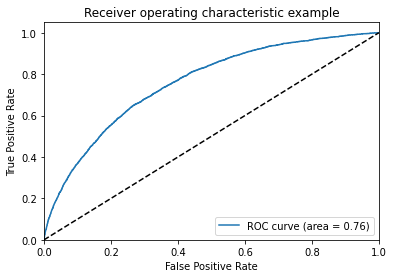

In [29]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


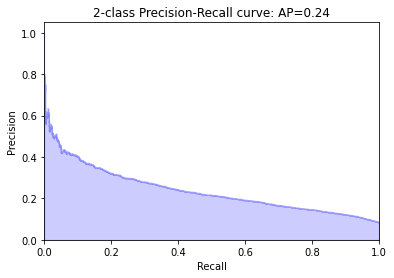

In [30]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()


In [ ]:

qsdjbfqsldjbfkjq


In [31]:
from sklearn.neighbors import KNeighborsClassifier


clf = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={
        "n_neighbors": [5, 7, 10],
        "weights": ["uniform", "distance"],
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=4,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


exception calling callback for <Future at 0x7efd94481640 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/clement/Workspace/oc_p4/env/lib/python3.9/site-pack

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

## 

In [ ]:
from sklearn.ensemble import RandomForestClassifier


clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid={
        "n_estimators": [10, 50, 100],
        "max_depth": [5, 10, 20],
        "max_features": ["auto", "sqrt", "log2"],
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="roc_auc",
    n_jobs=4,
    verbose=2,
)


clf.fit(X_train_std, y_train)


print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()


print(
    "ROC AUC score : ", roc_auc_score(y_true, y_pred),
)
print(
    "ROC curve score : ", roc_curve(y_true, y_pred),
)
print(
    "Accuracy score : ", accuracy_score(y_true, y_pred),
)
print(
    "Precision score : ", precision_score(y_true, y_pred),
)
print(
    "Recall score : ", recall_score(y_true, y_pred),
)
print(
    "F1 score : ", f1_score(y_true, y_pred),
)
print(
    "Confusion matrix : ", confusion_matrix(y_true, y_pred),
)
# print(
#     "Classification report : ",
#     classification_report(y_true, y_pred),
# )
print(
    "Precision-Recall curve : ", precision_recall_curve(y_true, y_pred),
)
print(
    "Average precision score : ", average_precision_score(y_true, y_pred),
)
print(
    "R2 score : ", r2_score(y_true, y_pred),
)
print(
    "Mean squared error : ", mean_squared_error(y_true, y_pred),
)
print(
    "Mean absolute error : ", mean_absolute_error(y_true, y_pred),
)
print(
    "Explained variance score : ", explained_variance_score(y_true, y_pred),
)
print(
    "Mean squared log error : ", mean_squared_log_error(y_true, y_pred),
)
print(
    "Median absolute error : ", median_absolute_error(y_true, y_pred),
)


Fitting 5 folds for each of 84 candidates, totalling 420 fits


KeyboardInterrupt: 

In [ ]:
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, color="b", alpha=0.2, where="post")
plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision)
)
plt.show()
